# Relaxed Poisson
Note: Implementation not yet differentiable

In [84]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
from torch.distributions import Poisson

import sys
sys.path.append('./..')
from piecewise_linear import PiecewiseLinear

In [2]:
def make_rect_poisson(r, n):
    # Returns pmf of a rectified poisson(k|r) with n knots
    r = torch.Tensor([[r]])
    k = torch.arange(0, n).float().view(1, -1)
    p = Poisson(r).log_prob(k).exp()
    p = p / p.sum(-1)
    return k, p

def make_knots(k, y_k, h_d, s):
    # Make 2-sided integer relaxation around k, which integrates to y_k
    x = torch.linspace(k-0.5, k+0.5, 7)
    h_k = (2 * y_k - h_d/3)
    h = torch.full_like(x, h_k)
    h_scale = torch.Tensor([0, s, 1-s, 1, 1-s, s, 0])
    h = h * h_scale
    h[0] += h_d
    h[-1] += h_d
    return x, h

def get_area(k, y):
    # To test if spline is normalized.
    area = 0
    for i in range(len(k)-1):
        area += (k[i+1] - k[i]) * (y[i] + y[i+1]) / 2
    return area

def make_knots_vec(k, y, h_d, s):
    x = 

In [3]:
def plot_poisson(rate, n):
    k, p = make_rect_poisson(rate, n)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.stem(k[0], p[0])
    ax1.set_ylim([0, p.max() + 0.05])

    print(f"Poisson({rate})")

    x = []
    y = []
    h_d = 1e-6
    s = 0.01
    for i in range(len(k[0])):
        x_i, y_i = make_knots(k[0, i].item(), p[0, i].item(), h_d, s)
        if i < len(k[0]) - 1:
            x_i = x_i[:-1]
            y_i = y_i[:-1]
        x.append(x_i)
        y.append(y_i)

    x = torch.cat(x)
    y = torch.cat(y)
    ax2.plot(x, y)
    plt.show()

    print('Area:', get_area(x, y).item())

Poisson(2)


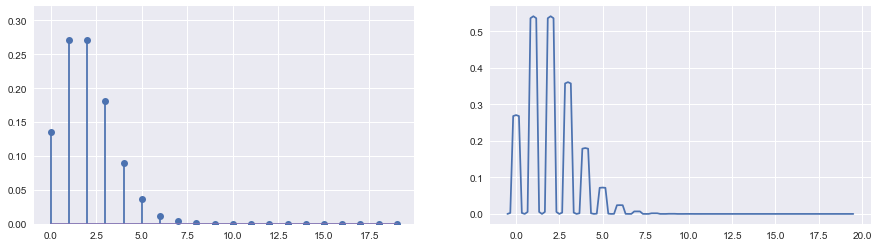

Area: 1.0000016689300537


In [4]:
plot_poisson(2, 20)

Poisson(10)


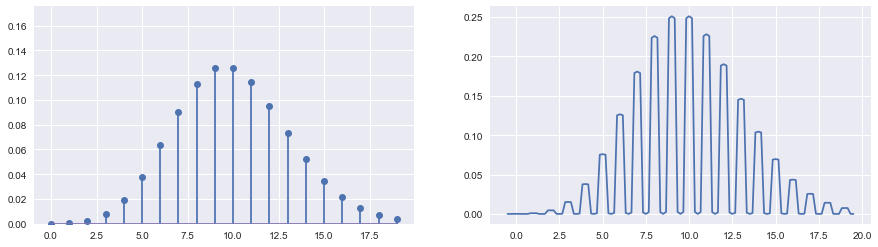

Area: 1.0000003576278687


In [5]:
plot_poisson(10, 20)

In [23]:
from torch.distributions import Normal

a = Normal(torch.Tensor([2]), torch.Tensor([10]))
a.sample()

tensor([28.5567])

In [59]:
a = torch.linspace(-0.5, 0.5, 7)[:-1].repeat(2, 5, 1)
k = torch.Tensor([[3, 4, 5, 6, 7], [10, 11, 12, 13, 14]])

h = torch.randint(0, 10, size=[2, 3, 4]).float().view(2, -1)
print(h)

h[..., -1:]

# final = torch.full([2, 1], 100).to(h.device)
# torch.cat([h, final], -1)

tensor([[8., 8., 5., 0., 8., 0., 7., 0., 1., 9., 3., 3.],
        [2., 2., 0., 5., 0., 6., 1., 2., 1., 0., 3., 2.]])


tensor([[3.],
        [2.]])

In [93]:
def make_knots(k, y_k, h_d, s):
    # Make 2-sided integer relaxation around k, which integrates to y_k
    x = torch.linspace(k-0.5, k+0.5, 7)
    h_k = (2 * y_k - h_d/3)
    h = torch.full_like(x, h_k)
    h_scale = torch.Tensor([0, s, 1-s, 1, 1-s, s, 0])
    h = h * h_scale
    h[0] += h_d
    h[-1] += h_d
    return x, h

def make_knots_vec(k, y, h_d, s):
    # k [batch, num_d, num_knots]
    # y [batch, num_d, num_knots]
    # h_d, s scalar hparams
    batch_size, num_d, num_k = k.shape

    # Each first and last spline knots overlap. Omit last one, and append final knot at end.
    # x [batch, num_knots, num_spline_knots-1]
    x = torch.linspace(-0.5, 0.5, 7)[:-1].repeat(batch_size, num_d, num_k, 1).to(k.device) + k.unsqueeze(-1)

    h_k = (2 * y - h_d/3)
    h_scale = torch.Tensor([0, s, 1-s, 1, 1-s, s]).repeat(batch_size, num_d, num_k, 1).to(k.device)
    h = h_scale * h_k.unsqueeze(-1)
    h[..., 0] = h_d

    x_final = k[..., -1:] + 0.5
    x = torch.cat([x.view(batch_size, num_d, -1), x_final], -1)
    h_final = torch.full([batch_size, num_d, 1], h_d)
    h = torch.cat([h.view(batch_size, num_d, -1), h_final], -1)
    return x, h

k = torch.arange(4).repeat(2, 1, 1)
y = torch.full_like(k.float(), 0.25)
print(k)
print(y)
k2, y2 = make_knots_vec(k, y, 1e-6, 0.1)
dist = PiecewiseLinear(k2, y2, x_range=(-0.5, 3.5))

tensor([[[0, 1, 2, 3]],

        [[0, 1, 2, 3]]])
tensor([[[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]]])


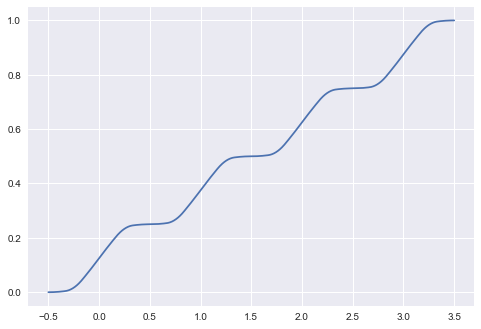

In [95]:
x = torch.linspace(-0.5, 3.5, 1000).repeat(2, 1, 1)
out = dist.cdf(x)
plt.plot(x[0].view(-1), out[0].view(-1))